
# Aeff factor

Joint model for cascade and track events. The cascade model is still for only a single flavour and interaction channel for simplicity. Now with Aeff factor as discussed in the Aachen meeting!

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
import stan_utility
import corner

from joint_model_cascades import * 
from aeff_calculator.aeff_calculator import effective_area_cascades, effective_area_tracks
from energy_conditional import EnergyConditional

In [2]:
random_seed = 19920715

## Simulation

#### Sources

Assume a predefined set of source and background component with fixed redshift, at the source population redshift threshold. This implements a *very crude* selection effect. 

In [3]:
# Use a set of sources uniform in comoving volume for a lambda-CDM universe.
with h5py.File('../data/test_SFR_pop.h5', 'r') as f:
    Ns = f['output/Ns'][()]
    redshift = f['output/redshift'][()]
    position = f['output/position'][()]
    
# Select sources within redshift zth to mimic catalogue
zth = 1.0
selection = np.where(redshift < zth)[0]
Ns = len(selection)
redshift = np.array([redshift[_] for _ in selection])
position = np.array([position[_] for _ in selection])
unit_vector = [p / np.linalg.norm(p) for p in position]

# Add background redshift
redshift = list(redshift) + [zth]

#### Effective area
Use same effective area as in precomputation! Now need both the effective area to muon tracks and cascade events/

In [4]:
from scipy.interpolate import RectBivariateSpline

# Tracks
aeff_tracks = effective_area_tracks()

# Cascades
aeff_cascades = effective_area_cascades("nue_CC")

... creating effective area spline for interaction nue_CC , done!


In [5]:
# Get Aeff factor as a function of arrival energy
E_grid_tracks = 10**np.linspace(2, 7, 100)
E_grid_cascades = 10**np.linspace(3, 7, 100)
cosz_bins_cascades = np.linspace(-1,1, 100)
cosz_bins_tracks = np.linspace(-1, 0.1, 100)
Pdet_grid_tracks = []
Pdet_grid_cascades = []

# Sources
for uv in unit_vector:
    # find source zenith angle
    cosz = np.cos(np.pi - np.arccos(uv[2]))
    
    # Get array
    if cosz > 0.1:
        Pgt = [0 for _ in E_grid_tracks]
    else:
        Pgt = [10**aeff_tracks.eval(np.log10(_), cosz)[0][0] for _ in E_grid_tracks]
    
    Pgc = [10**aeff_cascades.eval(np.log10(_), cosz)[0][0] for _ in E_grid_cascades]
    
    # Append
    Pdet_grid_tracks.append(np.array(Pgt)/max(Pgt))
    Pdet_grid_cascades.append(np.array(Pgc)/max(Pgc))


/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


In [6]:
# Background
aeff_vals_tracks = np.zeros((100,100))
for i,E in enumerate(E_grid_tracks):
    for j,cz in enumerate(cosz_bins_tracks):
        aeff_vals_tracks[i][j] = 10**aeff_tracks.eval(np.log10(E), cz)[0][0]
Pgt_bg = np.sum(aeff_vals_tracks, axis=1)
Pdet_grid_tracks.append(np.array(Pgt_bg)/max(Pgt_bg))

aeff_vals_cascades = np.zeros((100,100))
for i,E in enumerate(E_grid_cascades):
    for j,cz in enumerate(cosz_bins_cascades):
        aeff_vals_cascades[i][j] = 10**aeff_cascades.eval(np.log10(E), cz)[0][0]
Pgc_bg = np.sum(aeff_vals_cascades, axis=1)
Pdet_grid_cascades.append(np.array(Pgc_bg)/max(Pgc_bg))

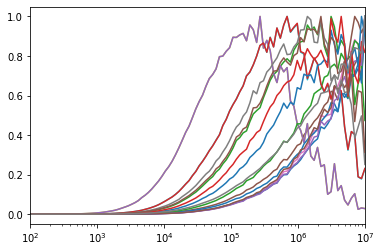

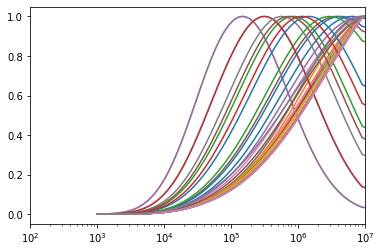

In [7]:
fig, ax = plt.subplots()
for pt in Pdet_grid_tracks:
    ax.plot(E_grid_tracks, pt)
ax.set_xscale('log')
ax.set_xlim(1e2,1e7)

fig, ax = plt.subplots()
for pc in Pdet_grid_cascades:
    ax.plot(E_grid_cascades, pc)
ax.set_xscale('log')
ax.set_xlim(1e2,1e7);

In [8]:
# Get input for spline evaluation in Stan
p = 3  # spline degree (default in RectBivariateSpline)

# Tracks
xknots_tracks, yknots_tracks = aeff_tracks.spline.get_knots()
c_tracks = aeff_tracks.spline.get_coeffs()

xknots_tracks = np.unique(xknots_tracks) 
yknots_tracks = np.unique(yknots_tracks)
Nx_tracks = len(xknots_tracks)+p-1
Ny_tracks = len(yknots_tracks)+p-1
c_tracks = c_tracks.reshape(Nx_tracks, Ny_tracks)

# Cascades
xknots_cascades, yknots_cascades = aeff_cascades.spline.get_knots()
c_cascades = aeff_cascades.spline.get_coeffs()

xknots_cascades = np.unique(xknots_cascades)
yknots_cascades = np.unique(yknots_cascades)
Nx_cascades = len(xknots_cascades)+p-1 
Ny_cascades = len(yknots_cascades)+p-1 
c_cascades = c_cascades.reshape(Nx_cascades, Ny_cascades)

# Maximum of the effective area, to scale 
aeff_max_cascades = max(10**aeff_cascades.aeff_vals) # m^2
aeff_max_tracks = 10**(aeff_tracks.log10_aeff_max) # m^2

#### Precomputed exposure integral
See `precomputation.ipynb` for info. Basically precomputes the integral over the effective area and spectral shape, then tabulates it in terms of alpha. 

In [9]:
# Get precomputed eps factor

# Tracks
with h5py.File('data/precomputed_integral_tracks_1e5.h5', 'r') as f:
    alpha_grid_tracks = f['alpha_grid'][()]
    integral_grid_tracks = np.nan_to_num(f['integral_grid'][()])

# Cascades
with h5py.File('data/precomputed_integral.h5', 'r') as f:
    alpha_grid_cascades = f['alpha_grid'][()]
    integral_grid_cascades = f['integral_grid'][()]

#### Energy resolution
See `conditionals.ipynb`.

In [10]:
# Tracks
# Coming soon

# Cascades
# Nue_CC
cond_file = ('data/conditional_2D_nue_CC_simulation_'
             +'gamma_1.0_lEmin_3.0_lEmax_7.0_fixed.txt')

energy_conditional = EnergyConditional(cond_file)

In [11]:
# Get input for spline evaluation in Stan
E_p = 1  # spline degree 
E_xknots, E_yknots = energy_conditional.spline.get_knots()
E_xknots = np.unique(E_xknots)
E_yknots = np.unique(E_yknots)
E_Nx = len(E_xknots)+E_p-1 
E_Ny = len(E_yknots)+E_p-1 
E_c = energy_conditional.spline.get_coeffs()
E_c = E_c.reshape(E_Nx, E_Ny)

#### Input parameters

Now define all input parameters, including those that we will fit for.

In [12]:
# Prepare simulation inputs that are defined above
sim_input = {}

# Sources
sim_input['Ns'] = Ns
sim_input['z'] = redshift
sim_input['D'] = [luminosity_distance(z) for z in redshift[:-1]] # Mpc
sim_input['varpi'] = unit_vector

# Exposure integral interpolation grid
sim_input['Ngrid'] = len(alpha_grid_tracks)
sim_input['alpha_grid_tracks'] = alpha_grid_tracks
sim_input['integral_grid_tracks'] = integral_grid_tracks
sim_input['alpha_grid_cascades'] = alpha_grid_cascades
sim_input['integral_grid_cascades'] = integral_grid_cascades

# Aeff Splines
sim_input['p'] = p

sim_input['Lknots_x_tracks'] = len(xknots_tracks)
sim_input['Lknots_y_tracks'] = len(yknots_tracks)
sim_input['xknots_tracks'] = xknots_tracks
sim_input['yknots_tracks'] = yknots_tracks
sim_input['c_tracks'] = c_tracks
sim_input['aeff_max_tracks'] = aeff_max_tracks

sim_input['Lknots_x_cascades'] = len(xknots_cascades)
sim_input['Lknots_y_cascades'] = len(yknots_cascades)
sim_input['xknots_cascades'] = xknots_cascades
sim_input['yknots_cascades'] = yknots_cascades
sim_input['c_cascades'] = c_cascades
sim_input['aeff_max_cascades'] = aeff_max_cascades

# Eres spline
sim_input['E_p'] = E_p
sim_input['E_Lknots_x'] = len(E_xknots)
sim_input['E_Lknots_y'] = len(E_yknots)
sim_input['E_xknots'] = E_xknots
sim_input['E_yknots'] = E_yknots
sim_input['E_c'] = E_c

In [20]:
sim_input['alpha_grid_tracks']

array([1.        , 1.01410147, 1.0284018 , 1.04290378, 1.05761026,
       1.07252413, 1.0876483 , 1.10298574, 1.11853947, 1.13431252,
       1.150308  , 1.16652904, 1.18297882, 1.19966056, 1.21657755,
       1.23373308, 1.25113054, 1.26877332, 1.2866649 , 1.30480877,
       1.3232085 , 1.34186769, 1.36079   , 1.37997915, 1.39943889,
       1.41917304, 1.43918547, 1.45948011, 1.48006093, 1.50093197,
       1.52209732, 1.54356114, 1.56532762, 1.58740105, 1.60978575,
       1.6324861 , 1.65550656, 1.67885164, 1.70252593, 1.72653405,
       1.75088073, 1.77557073, 1.80060889, 1.82600013, 1.85174942,
       1.87786182, 1.90434244, 1.93119648, 1.95842919, 1.98604593,
       2.01405211, 2.04245321, 2.07125481, 2.10046256, 2.13008218,
       2.16011948, 2.19058035, 2.22147076, 2.25279677, 2.28456453,
       2.31678026, 2.34945027, 2.38258098, 2.41617889, 2.45025057,
       2.48480272, 2.5198421 , 2.55537559, 2.59141015, 2.62795285,
       2.66501086, 2.70259145, 2.74070197, 2.77934991, 2.81854

In [21]:
# Define simulation parameters

# Energies
sim_input['alpha'] = 2.0
sim_input['Emin_tracks'] = 1e5 # GeV
sim_input['Emin_cascades'] = 1e4 # GeV

# Reconstruction 
sim_input['kappa_cascades'] = 100 # ~10 deg for cascades
sim_input['kappa_tracks'] = 500 #~1 degree for tracks

# Associated fraction  (derived paramaters, but easier to define this way)
total_flux = 30 # m^-2 yr^-1
f = 0.5

sim_input['T'] = 1 # yr
sim_input['F0'] = (1 - f) * total_flux # m^-2 yr^-1
sim_input['Q'] = ( (f*total_flux) / (sum([1 / (4*np.pi * (d*Mpc_to_m)**2) 
                                          for d in sim_input['D']])) ) # yr^-1 

In [23]:
sim_input['F0']

15.0

#### Run simulation

In [14]:
# Compile Stan model
sim = stan_utility.compile_model(filename = 'stan/tracks_and_cascades_sim.stan', 
                                 model_name = 'tracks_and_cascades_sim', 
                                 include_paths = 'stan/')

Using cached StanModel


In [15]:
# Simulate
simulation = sim.sampling(data=sim_input, iter=1, chains=1, 
                          algorithm="Fixed_param", seed = random_seed)

In [16]:
# Extract output
from fancy.interfaces.stan import Direction

# Energies
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E = simulation.extract(['E'])['E'][0]
Edet = simulation.extract(['Edet'])['Edet'][0]

# Arrival directions
event = simulation.extract(['event'])['event'][0]
event = Direction(event)
e_ra = event.d.icrs.ra.rad
e_dec = event.d.icrs.dec.rad

source = Direction(unit_vector)
s_ra = source.d.icrs.ra.rad
s_dec = source.d.icrs.dec.rad

# event type
event_type = simulation.extract(['event_type'])['event_type'][0]
zenith = simulation.extract(['zenith'])['zenith'][0]

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [17]:
# Labels
lam = simulation.extract(['lambda'])['lambda'][0] - 1
Nc = Ns
label_cmap = plt.cm.get_cmap('plasma', Nc+1)

lam = list(lam)
Nsrc = sum([lam.count(_) for _ in range(int(Nc))])
Nbg = lam.count(Nc)
print('Nsrc: ', Nsrc)
print('Nbg: ', Nbg)
print('w_bg: ', Nbg / (Nbg+Nsrc))

Nsrc:  32
Nbg:  22
w_bg:  0.4074074074074074


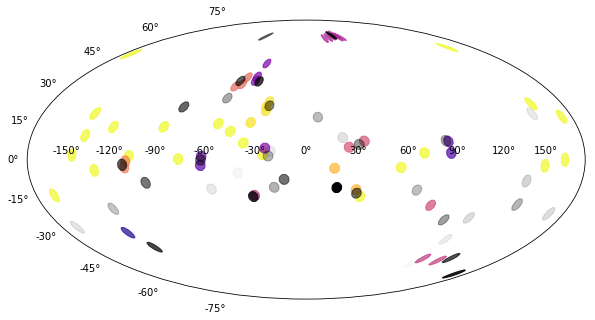

In [18]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure()
fig.set_size_inches((10, 8))
ax = fig.add_subplot(111, projection='hammer')

for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    circle = mpatches.Circle((r-np.pi,d), 0.05, color=color, alpha=0.7)
    ax.add_patch(circle)
norm = max([1 - _/zth for _ in redshift])
for r, d, z in zip(s_ra, s_dec, redshift):
    circle = mpatches.Circle((r-np.pi,d), 0.05, color='k', alpha=(1-z/zth)/norm)
    ax.add_patch(circle)

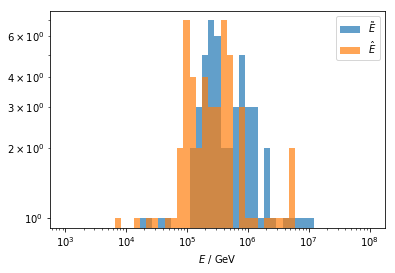

In [19]:
# Plot energies
Emin_cascades = sim_input['Emin_cascades']
bins = np.logspace(np.log(Emin_cascades/10), np.log(1E+4*Emin_cascades), base = np.e)

fig, ax = plt.subplots()
ax.hist(Esrc, bins=bins, label='$\\tilde{E}$', alpha=0.7);
ax.hist(Edet, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

## Fitting the model

In [20]:
# Prepare fit inputs
fit_input = {}
fit_input['N_tracks'] = len(event.unit_vector[event_type == 1])
fit_input['N_cascades'] = len(event.unit_vector[event_type == 2])
fit_input['omega_det_tracks'] = event.unit_vector[event_type == 1]
fit_input['omega_det_cascades'] = event.unit_vector[event_type == 2]
fit_input['Emin_cascades'] = sim_input['Emin_cascades']
fit_input['Emin_tracks'] = sim_input['Emin_tracks']
fit_input['Edet_tracks'] = Edet[event_type == 1]
fit_input['Edet_cascades'] = Edet[event_type == 2]
fit_input['Ns'] = Ns
fit_input['varpi'] = source.unit_vector
fit_input['D'] = sim_input['D']
fit_input['z'] = sim_input['z']
fit_input['kappa_tracks'] = sim_input['kappa_tracks']
fit_input['kappa_cascades'] = sim_input['kappa_cascades']
fit_input['Ngrid'] = sim_input['Ngrid'] 
fit_input['alpha_grid_tracks'] = sim_input['alpha_grid_tracks'] 
fit_input['integral_grid_tracks'] = sim_input['integral_grid_tracks'] 
fit_input['alpha_grid_cascades'] = sim_input['alpha_grid_cascades'] 
fit_input['integral_grid_cascades'] = sim_input['integral_grid_cascades'] 
fit_input['T'] = sim_input['T']
fit_input['E_grid_tracks'] = E_grid_tracks
fit_input['E_grid_cascades'] = E_grid_cascades
fit_input['Pdet_grid_tracks'] = Pdet_grid_tracks
fit_input['Pdet_grid_cascades'] = Pdet_grid_cascades

# Debugging
fit_input['Q_scale'] = sim_input['Q']
fit_input['F0_scale'] = sim_input['F0']

In [21]:
# Compile the model
model = stan_utility.compile_model(filename = 'stan/tracks_and_cascades_model.stan', 
                                   model_name = 'tracks_and_cascades_model', 
                                   include_paths = 'stan/')

Using cached StanModel


In [22]:
fit = model.sampling(data = fit_input, iter = 1000, chains = 4, seed = random_seed)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


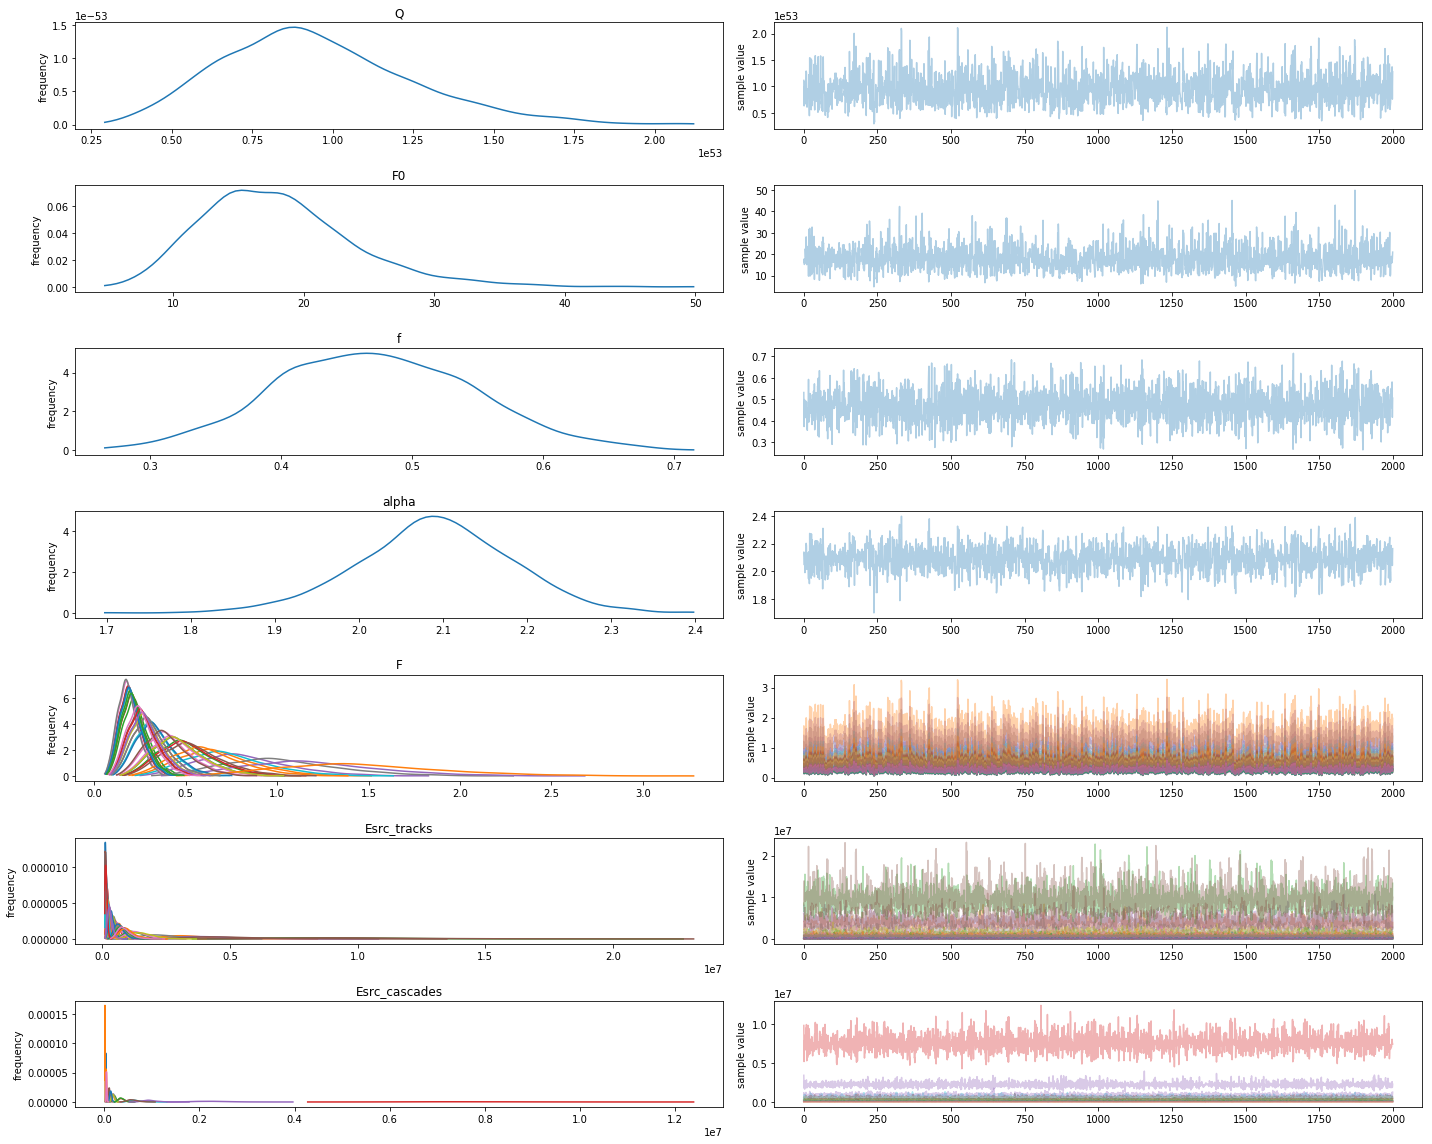

In [23]:
# View chains
fig = fit.plot([r'Q', r'F0', r'f', r'alpha', r'F', r'Esrc_tracks', r'Esrc_cascades']);
fig.set_size_inches(20, 16)
fig.tight_layout()

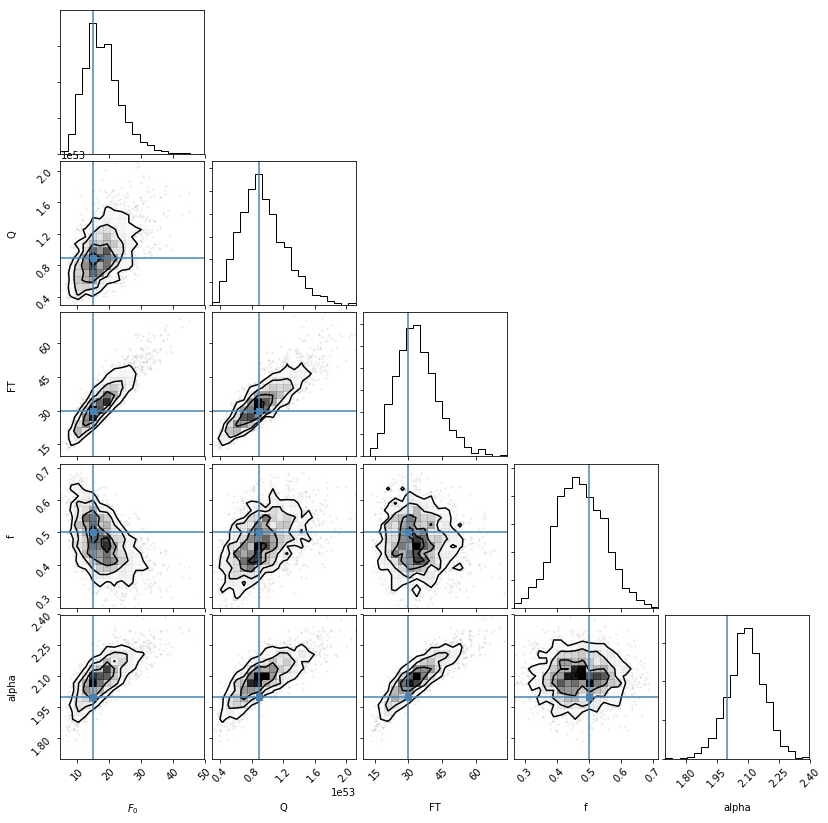

In [24]:
# View corner plot
chain = fit.extract(permuted = True)
key_list = ['F0', 'Q', 'FT', 'f', 'alpha']
labels = [r'$F_0$', r'Q', r'FT', r'f', 'alpha']
truths = [sim_input['F0'], sim_input['Q'], total_flux, f, sim_input['alpha']]

corner.corner(np.nan_to_num(np.column_stack([chain[key] for key in key_list])),
              labels = labels, 
              truths = truths);

## Association probabilities

In [25]:
chain = fit.extract(permuted = True)
logprob = chain['lp_cascades'].transpose(1, 2, 0)
N = np.shape(logprob)[0]

# Account for background component
Ns = np.shape(logprob)[1] - 1

In [26]:
# Calculate association probabilities for each source-neutrino combo
nu_p = []
for lp in logprob:
    lps = []
    for src in range(Ns+1):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns+1):
        ps.append(lps[src] / norm)
    nu_p.append(ps)

# Normalise line weights
pmax = max(max(nu_p))

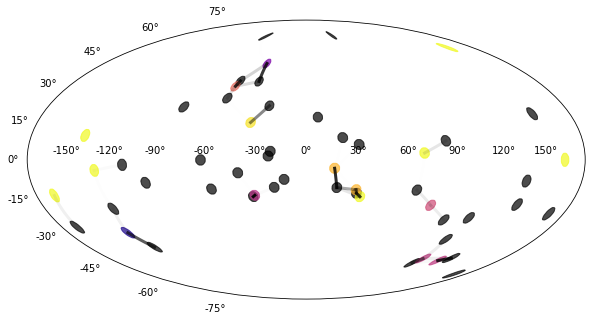

In [48]:
# Figure
fig = plt.figure()
fig.set_size_inches((10, 8))

ax = fig.add_subplot(111, projection='hammer')

# Sources
for r, d in zip(s_ra, s_dec):
    circle = mpatches.Circle((r-np.pi,d), 0.05, color='k', alpha=0.7)
    ax.add_patch(circle)
    
# Neutrinos
inds = np.where(event_type == 2)[0]
e_ra = [e_ra[_] for _ in inds] 
e_dec = [e_dec[_] for _ in inds] 
lam = [lam[_] for _ in inds] 

for r, d, l in zip(e_ra, e_dec, lam):
    color = label_cmap.colors[int(l)]
    circle = mpatches.Circle((r-np.pi,d), 0.05, color=color, alpha=0.7)
    ax.add_patch(circle)

# Association
for i, p in enumerate(nu_p):
    for j, psrc in enumerate(p[0:Ns]):
        if psrc > 0.001:
            ax.plot([e_ra[i]-np.pi, s_ra[j]-np.pi],
                    [e_dec[i], s_dec[j]], 
                    color='black', lw=3, alpha=psrc)